## Minimal example that demonstrates how to use Roboflow with ReductStore

Import the necessary libraries

In [49]:
import time

from flatten_json import flatten, unflatten
from inference_sdk import InferenceHTTPClient
from matplotlib import pyplot as plt
import supervision as sv
import numpy as np
import cv2
from reduct import Client, Bucket

Import image to be processed

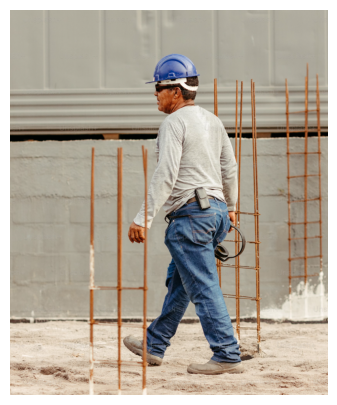

In [50]:
image = cv2.imread("img/image_example.png")

fig = plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Example of using the InferenceHTTPClient to make a request to the Roboflow Inference API

In [51]:
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="0V9NRqITldFn0MFxy9jb",  # Public API key for demonstration purposes
)
predictions = CLIENT.infer(image, model_id="hard-hat-sample-hicg4/3")

Extract the labels and detections from the result

In [11]:
labels = [item["class"] for item in predictions["predictions"]]
detections = sv.Detections.from_inference(predictions)

label_annotator = sv.LabelAnnotator()
box_annotator = sv.BoxAnnotator()

annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

Show the image with the detections

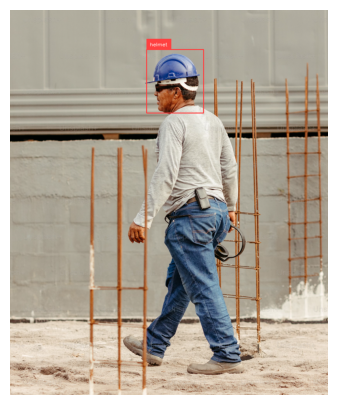

In [12]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Functions to convert image to bytes and back

In [13]:
def image_to_bytes(image: np.ndarray) -> bytes:
    _, im_buf_arr = cv2.imencode(".png", image)
    return im_buf_arr.tobytes()


def bytes_to_image(byte_im: bytes) -> np.ndarray:
    nparr = np.frombuffer(byte_im, np.uint8)
    return cv2.imdecode(nparr, cv2.IMREAD_COLOR)


image_bytes = image_to_bytes(image)
image_reconstructed = bytes_to_image(image_bytes)

assert np.array_equal(image, image_reconstructed)

Functions to flatten and unflatten the detections

In [103]:
def flatten_predictions(predictions: dict) -> dict:
    return flatten(predictions, ".")


def unflatten_predictions(predictions: dict) -> dict:
    unflattened_predictions = unflatten(predictions, ".")
    unflattened_predictions["predictions"] = list(
        unflattened_predictions["predictions"].values()
    )
    return unflattened_predictions


flat_predictions = flatten_predictions(predictions)
unflattened_predictions = unflatten_predictions(flat_predictions)

assert unflattened_predictions == predictions

In [85]:
flat_predictions

{'inference_id': '1e2a95cf-a5b0-40de-ba4a-f8cf11d0dbbb',
 'time': 0.1298439550000694,
 'image.width': 960,
 'image.height': 1164,
 'predictions.0.x': 498.0,
 'predictions.0.y': 215.0,
 'predictions.0.width': 172.0,
 'predictions.0.height': 192.0,
 'predictions.0.confidence': 0.9607089757919312,
 'predictions.0.class': 'helmet',
 'predictions.0.class_id': 1,
 'predictions.0.detection_id': '0e2ab537-da1a-4da0-8f7b-e2b0745ba453'}

Save the image and detections to ReductStore

In [86]:
async with Client("http://127.0.0.1:8383", api_token="my-token") as client:
    bucket: Bucket = await client.create_bucket("my-bucket", exist_ok=True)
    ts = time.time()
    await bucket.write(
        "roboflow",
        image_bytes,
        ts,
        labels=flat_predictions,
        content_type="text/plain",
    )

Retrieve the image and detections from ReductStore

In [107]:
async with Client("http://127.0.0.1:8383", api_token="my-token") as client:
    bucket: Bucket = await client.get_bucket("my-bucket")

    async with bucket.read("roboflow", ts) as record:
        content = await record.read_all()
        image_reconstructed = bytes_to_image(content)
        label_reconstructed = unflatten_predictions(record.labels)

        assert np.array_equal(image, image_reconstructed)

In [108]:
label_reconstructed

{'image': {'height': '1164', 'width': '960'},
 'inference_id': '1e2a95cf-a5b0-40de-ba4a-f8cf11d0dbbb',
 'predictions': [{'class': 'helmet',
   'class_id': '1',
   'confidence': '0.9607089757919312',
   'detection_id': '0e2ab537-da1a-4da0-8f7b-e2b0745ba453',
   'height': '192.0',
   'width': '172.0',
   'x': '498.0',
   'y': '215.0'}],
 'time': '0.1298439550000694'}